# Test Data 

The dataset will contain the following: 
- app (Textnow, Gamechanger, OKC, AllTrails)
- grafana url - link containing the query logs info for the requests made for the given sample rate.
- Pageload duration - end-user perspective 
- query logs - logs will contain the query & payload duration

The flamegraph page will be loaded 5x for each sample rate (100 default, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90)

In [1]:
import yaml
import pandas
import re
import matplotlib.pyplot as pyplot
import seaborn

In [2]:
yaml_file = open('/Users/embrace/Documents/data-analysis/data-sources/qa_flamegraph_sampling.yml', 'r')
yaml_content = yaml.load(yaml_file, Loader=yaml.Loader)

In [3]:
def yaml_df(yaml_content):
    data = [
        {
            'app': app['app'], 'grafana_url': app['grafana_url'], 'sample_rate': app['sample_rate'], 
            'pageload_duration': app['pageload_duration'], 'query_log': app['query_log']
        } 
        for app in yaml_content['flamegraph_sampling_rates']
    ]
    
    df = pandas.DataFrame(data)
    
    # Transform list to rows. 
    df = df.explode(['pageload_duration', 'query_log'], ignore_index=True)
    
    # Get pageload duration load values
    df['pageload_duration'] = [pageload if pageload != 0 else 0.01 for pageload in df['pageload_duration']]
    
    # Get query duration from query log (convert to seconds)
    df['query_duration'] = [
        round(float(query[0]) / 1000, 2) if query[0] != '0' else 0.01 for query in 
            [re.findall('"query":(.+?),', query) if query else ['0'] for query in df['query_log']]
    ]

    # Get payload duration from query log
    df['payload_duration'] = [
        round(float(payload[0]) , 2) if payload[0] != '0' else 0.01 for payload in [
            re.findall('"payload_dur":(.+?),', payload) if payload else ['0'] for payload in df['query_log']
        ]
    ]
    
    return df
    

In [4]:
df = yaml_df(yaml_content)
df

,app,grafana_url,sample_rate,pageload_duration,query_log,query_duration,payload_duration
0,TextNow DiFBd,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,100,6.46,"2022-02-11T15:26:25.844044081Z stderr F {""leve...",3.65,2.50
1,TextNow DiFBd,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,100,5.11,"2022-02-11T15:26:59.544744495Z stderr F {""leve...",3.76,1.41
2,TextNow DiFBd,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,100,4.89,"2022-02-11T15:27:15.31972745Z stderr F {""level...",4.58,2.13
3,TextNow DiFBd,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,100,5.18,"2022-02-11T15:27:30.726005087Z stderr F {""leve...",3.60,6.15
4,TextNow DiFBd,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,100,4.83,"2022-02-11T15:27:44.661139732Z stderr F {""leve...",3.37,1.20
...,...,...,...,...,...,...,...
270,AllTrails rEvQ4,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,90,3.20,"2022-02-15T23:00:36.826857029Z stderr F {""leve...",0.31,2.32
271,AllTrails rEvQ4,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,90,2.06,"2022-02-15T23:00:43.021351459Z stderr F {""leve...",0.32,2.09
272,AllTrails rEvQ4,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,90,2.19,"2022-02-15T23:00:50.15468537Z stderr F {""level...",0.31,2.17
273,AllTrails rEvQ4,https://grafana.emb-eng.com/d/S6ZwBx-nk/flameg...,90,2.00,"2022-02-15T23:00:56.191290308Z stderr F {""leve...",0.30,2.17


In [5]:
duration_averages = df.groupby(['app', 'sample_rate'], as_index=False).mean().round(2)
duration_averages = duration_averages.sort_values(['app', 'sample_rate'], ascending=[True, True], ignore_index=True)
duration_averages['rank'] = duration_averages.groupby('app')['sample_rate'].rank('dense', ascending=True).astype(int)
duration_averages

,app,sample_rate,pageload_duration,query_duration,payload_duration,rank
0,AllTrails rEvQ4,5,2.03,0.24,1.79,1
1,AllTrails rEvQ4,10,2.13,0.25,1.63,2
2,AllTrails rEvQ4,20,2.35,0.26,3.60,3
3,AllTrails rEvQ4,30,2.36,0.30,2.63,4
4,AllTrails rEvQ4,40,2.61,0.29,2.87,5
5,AllTrails rEvQ4,50,2.30,0.29,3.57,6
6,AllTrails rEvQ4,60,3.56,0.32,2.35,7
7,AllTrails rEvQ4,70,2.31,0.32,4.99,8
8,AllTrails rEvQ4,80,2.37,0.33,3.41,9
9,AllTrails rEvQ4,90,2.38,0.31,2.64,10


In [6]:
default_sample_rate = duration_averages.sort_values(['app', 'rank'], ascending=[True, False]).groupby('app', as_index=False).first()
default_sample_rate = default_sample_rate.rename(columns={
    'sample_rate': 'default_sample_rate', 'pageload_duration': 'default_pageload_duration',
    'query_duration': 'default_query_duration', 'payload_duration' : 'default_payload_duration'
})

default_sample_rate
default_sample_rate


,app,default_sample_rate,default_pageload_duration,default_query_duration,default_payload_duration,rank
0,AllTrails rEvQ4,100,2.31,0.34,3.86,11
1,GameChanger CHYiM,100,2.46,0.25,5.83,11
2,OkCupid 28r9d,100,3.69,1.09,8.36,11
3,TextNow DiFBd,100,5.29,3.79,2.68,11
4,War Machines jzjSv,100,2.29,0.45,0.99,11


In [7]:
percent_change = duration_averages.merge(
    default_sample_rate[['app', 'default_pageload_duration', 'default_query_duration', 'default_payload_duration']], 
    how='inner', on='app')

percent_change['pageload_duration_percent_change'] = ((
    (percent_change['default_pageload_duration'] - percent_change['pageload_duration']) 
     / percent_change['default_pageload_duration']) * 100).round(0).astype(int)

percent_change['query_duration_percent_change'] = ((
    (percent_change['default_query_duration'] - percent_change['query_duration']) 
     / percent_change['default_query_duration']) * 100).round(0).astype(int)

percent_change['payload_duration_percent_change'] = ((
    (percent_change['default_payload_duration'] - percent_change['payload_duration']) 
     / percent_change['default_payload_duration']) * 100).round(0).astype(int)


percent_change

,app,sample_rate,pageload_duration,query_duration,payload_duration,rank,default_pageload_duration,default_query_duration,default_payload_duration,pageload_duration_percent_change,query_duration_percent_change,payload_duration_percent_change
0,AllTrails rEvQ4,5,2.03,0.24,1.79,1,2.31,0.34,3.86,12,29,54
1,AllTrails rEvQ4,10,2.13,0.25,1.63,2,2.31,0.34,3.86,8,26,58
2,AllTrails rEvQ4,20,2.35,0.26,3.60,3,2.31,0.34,3.86,-2,24,7
3,AllTrails rEvQ4,30,2.36,0.30,2.63,4,2.31,0.34,3.86,-2,12,32
4,AllTrails rEvQ4,40,2.61,0.29,2.87,5,2.31,0.34,3.86,-13,15,26
5,AllTrails rEvQ4,50,2.30,0.29,3.57,6,2.31,0.34,3.86,0,15,8
6,AllTrails rEvQ4,60,3.56,0.32,2.35,7,2.31,0.34,3.86,-54,6,39
7,AllTrails rEvQ4,70,2.31,0.32,4.99,8,2.31,0.34,3.86,0,6,-29
8,AllTrails rEvQ4,80,2.37,0.33,3.41,9,2.31,0.34,3.86,-3,3,12
9,AllTrails rEvQ4,90,2.38,0.31,2.64,10,2.31,0.34,3.86,-3,9,32


In [8]:
summary = percent_change[[
    'app', 'sample_rate', 'pageload_duration', 'pageload_duration_percent_change',
    'query_duration', 'query_duration_percent_change', 'payload_duration', 'payload_duration_percent_change'
]]

summary

,app,sample_rate,pageload_duration,pageload_duration_percent_change,query_duration,query_duration_percent_change,payload_duration,payload_duration_percent_change
0,AllTrails rEvQ4,5,2.03,12,0.24,29,1.79,54
1,AllTrails rEvQ4,10,2.13,8,0.25,26,1.63,58
2,AllTrails rEvQ4,20,2.35,-2,0.26,24,3.60,7
3,AllTrails rEvQ4,30,2.36,-2,0.30,12,2.63,32
4,AllTrails rEvQ4,40,2.61,-13,0.29,15,2.87,26
5,AllTrails rEvQ4,50,2.30,0,0.29,15,3.57,8
6,AllTrails rEvQ4,60,3.56,-54,0.32,6,2.35,39
7,AllTrails rEvQ4,70,2.31,0,0.32,6,4.99,-29
8,AllTrails rEvQ4,80,2.37,-3,0.33,3,3.41,12
9,AllTrails rEvQ4,90,2.38,-3,0.31,9,2.64,32


<AxesSubplot:xlabel='sample_rate', ylabel='payload_duration_percent_change'>

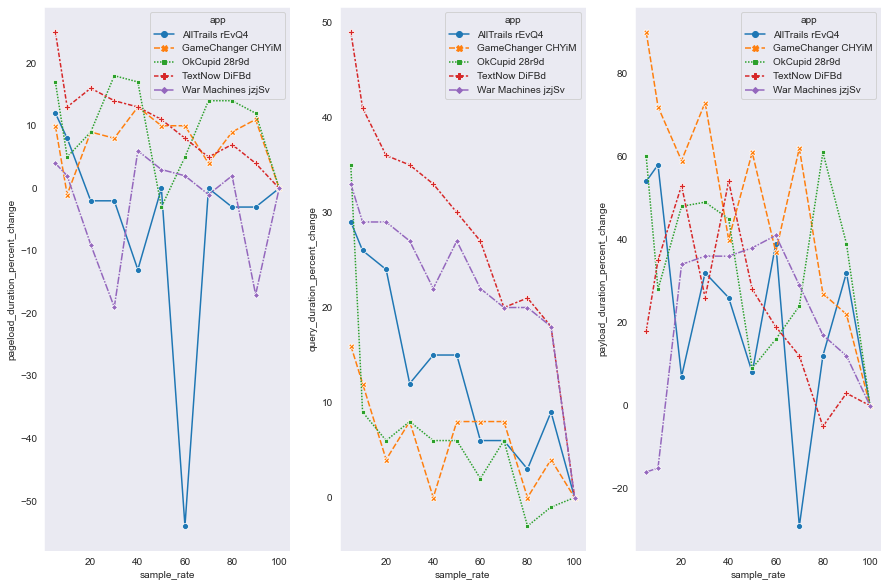

In [9]:
seaborn.set_style('dark')
pyplot.figure(figsize=(15,10))
pyplot.subplot(1,3,1)
seaborn.lineplot(data=summary, x='sample_rate', y='pageload_duration_percent_change', hue='app', style='app', ci=None, markers=True)

pyplot.subplot(1,3,2)
seaborn.lineplot(data=summary, x='sample_rate', y='query_duration_percent_change', hue='app', style='app', ci=None, markers=True)

pyplot.subplot(1,3,3)
seaborn.lineplot(data=summary, x='sample_rate', y='payload_duration_percent_change', hue='app', style='app', ci=None, markers=True)
